In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

import datetime
from ngram import *
from baselines import *
from error_analysis import *
import os
import fnmatch
import numpy as np
import time
import multiprocessing as mp
import re 

In [2]:
import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from data_generation.diff_utils import clean_and_filter

# Run Models

#### Load Models

In [38]:
m_agg = joblib.load( '../../models/aggression_regression_ngram.pkl')
m_rec = joblib.load( '../../models/recipient_ngram.pkl')

#### Load annotationed diffs

In [40]:
_ , d_r = load_cf_data()
d_annotations = tidy_labels(d_r)

d_annotated = d_annotations\
            .drop_duplicates(subset=['rev_id'])\
            .assign(
                recipient = plurality(d_annotations['recipient'].dropna()),
                recipient_score = average(d_annotations['recipient'].dropna()),
                aggression = average(d_annotations['aggression_score'].dropna()),
                rev_timestamp = lambda x: pd.to_datetime(x.rev_timestamp),
                pred_aggression_score = lambda x: m_agg.predict(x['clean_diff']),
                pred_recipient_score = lambda x: m_rec.predict(x['clean_diff']))

#### Load samples and apply models

We take various diffs datasets from hive, apply the clean and filter function and the score the clean diffs using the models.

In [5]:
def pred_helper(df):
    df = clean_and_filter(df)
    if len(df) == 0:
        return None
    
    return df.assign(rev_timestamp = lambda x: pd.to_datetime(x.rev_timestamp),
                     pred_aggression_score = lambda x: m_agg.predict(x['clean_diff']),
                     pred_recipient_score = lambda x: m_rec.predict(x['clean_diff']))

    
def prep_in_parallel(path, k = 8):
    names = ['rev_comment', 'diff', 'insert_only', 'rev_id', 'page_id', 'page_title', 'rev_timestamp', 'user_id', 'user_text']
    df = pd.read_csv(path, sep = '\t', quoting = 3, encoding = 'utf-8', header = None, usecols = range(9))\
           .rename(columns=names)\
           .assign(key = lambda x: np.random.randint(0, high=5*k, size=x.shape[0])
    dfs = [e[1] for e in df.groupby('key')]
    p = mp.Pool(k)
    dfs = p.map(pred_helper, dfs)
    p.close()
    p.join()
    return pd.concat(dfs)

def prep_data(path, m_rec, m_agg):
    files = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    dfs = [prep_in_parallel(p, k = 6) for p in files]
    cols = ['rev_id', 'clean_diff', 'rev_timestamp', 'pred_aggression_score', 'pred_recipient_score', 'page_title', 'user_text','user_id']
    df = pd.concat(dfs)
    return df [cols]

In [6]:
%%capture
df_no_admin_sample  = prep_data('../../data/user_talk_diff_no_admin_sample',  m_rec, m_agg)
#df_no_bot_sample  = prep_data('../../data/user_talk_diff_no_bot_sample', m_rec, m_agg)
df_no_admin_2015  = prep_data('../../data/user_talk_diff_no_admin/year=2015',  m_rec, m_agg)
#df_no_bot_2015    = prep_data('../../data/user_talk_diff_no_bot/year=2015',  m_rec, m_agg)
df_blocked_user  = prep_data('../../data/blocked_user_talk_diff_no_admin', m_rec, m_agg)

d_annotated.to_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample.to_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample.to_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015.to_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015.to_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user.to_csv('df_blocked_user.tsv', sep = '\t')

# Load Predictions

#### Load model predictions

In [103]:
d_annotated = pd.read_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample = pd.read_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample = pd.read_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015 = pd.read_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015 = pd.read_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user = pd.read_csv('df_blocked_user.tsv', sep = '\t')

#### Load block events

In [104]:
def is_ip(x):
    pattern = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"
    return re.match(pattern,str(x)) is not None

df_events = pd.read_csv('../../data/v4/block_events.tsv', sep = '\t')\
                .rename(columns= lambda x: x.split('.')[1])\
                .assign(timestamp= lambda x: pd.to_datetime(x.timestamp),
                        anon = lambda x: x.user_text.apply(is_ip))
                        
                        
df_events['year'] = df_events['timestamp'].apply(lambda x: x.year)
df_events['month'] = df_events['timestamp'].apply(lambda x: x.month)
df_events['hour'] = df_events['timestamp'].apply(lambda x: x.hour)

#### Augment with some easy features

In [165]:
for df in [df_blocked_user, df_no_admin_sample, df_no_admin_2015, d_annotated]:
    df['author_anon'] = df['user_id'].isnull()
    df['recipient_anon'] = df['page_title'].apply(is_ip)
    df['rev_timestamp'] = pd.to_datetime(df['rev_timestamp'])
    df['year'] = df['rev_timestamp'].apply(lambda x: x.year)
    df['month'] = df['rev_timestamp'].apply(lambda x: x.month)
    df['hour'] = df['rev_timestamp'].apply(lambda x: x.hour)
    df['pred_aggression_score'] = -1 * df['pred_aggression_score']
    df['pred_recipient'] = (df['pred_recipient_score'] > 0.5).astype(int)
    df['own_page'] = df['user_text'] == df['page_title']
    
d_annotated['aggression'] = d_annotated['aggression'] * -1


df_blocked_user_text = df_events[['user_text']]\
                    .drop_duplicates()\
                    .assign(blocked = 1)  
        
df_blocked_user['blocked'] = 1

# Model Checking

### Q: What do comments in different score intervals look like?

In [20]:
def check_range(d, col, min, max, n = 10, ):
    df = d.query('%s >= %f and %s <= %f' % (col, min, col, max))
    for i, r in df.sample(n).iterrows():
        print(r[col])
        print(r.clean_diff)
        print('\n')  
    

In [22]:
#check_range(df_no_admin_sample, 'pred_aggression_score', -2, -1)

### Q: How does the distribution over aggression scores compare across annotators vs models and different data sets

Plot kernel density estimate of aggression score distribution. This is mainly a sanity check that the aggression model is working new data

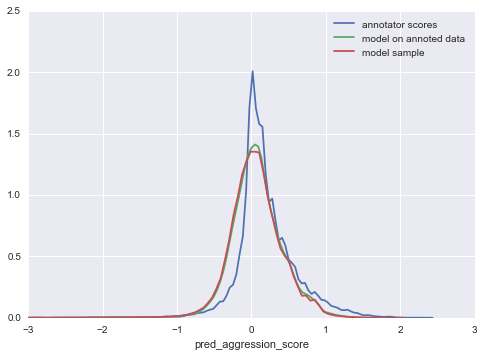

In [163]:
# annotations
sns.distplot(d_annotated['aggression'].dropna(), hist=False, label = 'annotator scores')

# model on annotated data
sns.distplot(d_annotated['pred_aggression_score'].dropna(), hist=False, label = 'model on annoted data')

#model no admin sample
sns.distplot(df_no_admin_sample['pred_aggression_score'].dropna(), hist=False, label = 'model sample')

plt.xlim(-3, 3)
plt.legend()

It looks like the model is over-predicting. Probably because most comments in training where blocked comments.

### Q: How does the distribution over attack probabilities compare across annotators vs models and different data sets

This is mainly a sanity check that the attack model is working new data

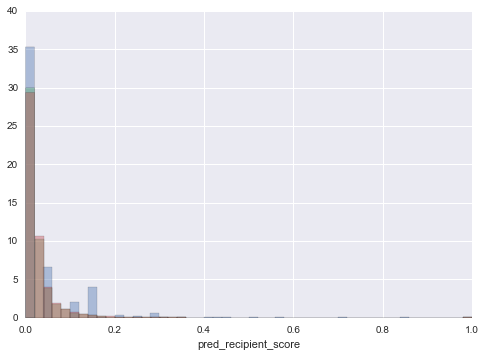

In [24]:
sns.distplot(d_annotated['recipient_score'].dropna(), kde =False, norm_hist = True)
sns.distplot(d_annotated['pred_recipient_score'].dropna(), kde =False, norm_hist = True)
sns.distplot(df_no_admin_sample['pred_recipient_score'].dropna(), kde =False, norm_hist = True)

# Quantifying Prevalence of Personal Attacks

### Q: What fraction of comments are personal attacks?

Methodology 1:
Let p be the proportion of comments that where labled as a personal attack by more than half the annotators. 
Treat p as a random variable, with a weak/uniform beta prior. Compute posterior distribution of p using the number of comments and the number of comments labeled as attacks. Form 95% credible interval using the posterior.

In [200]:
from numpy.random import  beta

def get_credible_interval(num_events, num_trials, conf, num_samples = 50000):
    dist = beta(num_events+1, num_trials-num_events+1, num_samples)
    lower = (100.0 - conf)/2.0
    upper = conf + lower
    return tuple(np.percentile(dist, [lower, upper]))
    

In [201]:
# annotators:
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(d_annotated['recipient'].sum(), d_annotated.shape[0], 95)

'Fraction of comments labeled as attacks: (0.006, 0.009)'

In [202]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(d_annotated['pred_recipient'].sum(), d_annotated.shape[0], 95)

'Fraction of comments labeled as attacks: (0.005, 0.008)'

In [204]:
# model sample data: Not really meaninggful, just a comparison
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(df_no_admin_sample['pred_recipient'].sum(), df_no_admin_sample.shape[0], 95)

'Fraction of comments labeled as attacks: (0.005, 0.006)'

Methodology 2: Compute fraction of comments predicted to be attacks for different classification thresholds

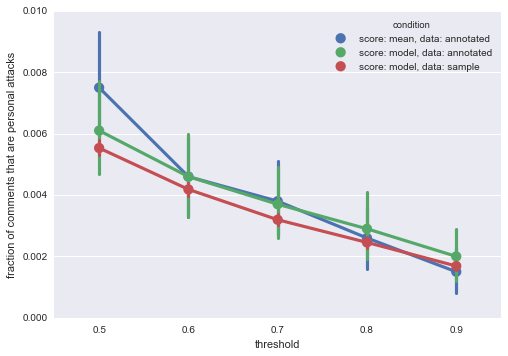

In [29]:
ts = np.arange(0.5, 0.91, 0.1)

# score = mean of annotations
d_aa = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['recipient_score'] >= t }) for t in ts], axis = 0)
d_aa['condition'] = 'score: mean, data: annotated'

# score = model score on annotated data
d_ma = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['pred_recipient_score'] >= t }) for t in ts], axis = 0) 
d_ma['condition'] = 'score: model, data: annotated'

# score = model score on sample data
d_ms = pd.concat([pd.DataFrame({'threshold': t, 'attack': df_no_admin_sample['pred_recipient_score'] > t }) for t in ts], axis = 0) 
d_ms['condition'] = 'score: model, data: sample' 

sns.pointplot(x="threshold", y="attack", hue="condition", data=pd.concat([d_aa, d_ma, d_ms]))
plt.ylabel('fraction of comments that are personal attacks')

Methodology 3: 
For each comment, label it as a personal attack with the probability assigned by the model/annotators. Count the number of comments labeled as personal attacks. Repeat to get a distribtion and take 95% interval.

In [30]:
def compute_ci(a, n = 1000):
    m = a.shape[0]
    v = a.values.reshape((m,1))
    fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
    print("Fraction of comments labeled as attacks: (%.4f, %.4f)" % ( np.percentile(fs, 2.5), np.percentile(fs, 97.5)))
    
    
# annotator probs
print('Scores: mean annotation, Data: annotated')
compute_ci(d_annotated['recipient_score'])

# model probs on annotator data
print('Scores: model, Data: annotated')
compute_ci(d_annotated['pred_recipient_score'])

# model on sample data
print('Scores: model, Data: sample')
compute_ci(df_no_admin_sample['pred_recipient_score'])

Scores: mean annotation, Data: annotated
Fraction of comments labeled as attacks: (0.0338, 0.0402)
Scores: model, Data: annotated
Fraction of comments labeled as attacks: (0.0322, 0.0387)
Scores: model, Data: sample
Fraction of comments labeled as attacks: (0.0349, 0.0360)


### Q: What fraction of users have made a personal attack?

Methodology 1: Take unsampled data. Compute fraction of people who authored one comment above the threshold for different thresholds.

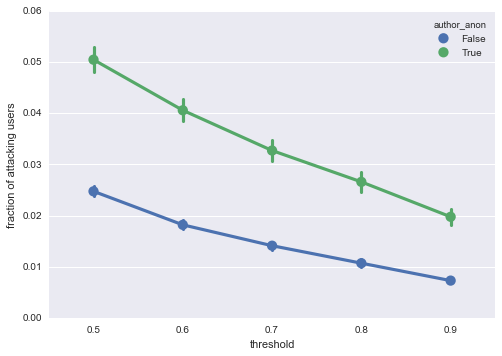

In [46]:
ts = np.arange(0.5, 0.91, 0.1)
dfs = []

for t in ts:
    
    dfs.append (\
                df_no_admin_2015.assign(attack= lambda x: x.pred_recipient_score > t)\
                .groupby(['user_text', 'author_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'author_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacking users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with proabbility equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [41]:
def simulate_num_attacks(df, group_col = 'user_text'):
    n = df.assign( uniform = np.random.rand(df.shape[0], 1))\
            .assign(is_attack = lambda x: (x.pred_recipient_score > x.uniform).astype(int))\
            .groupby(group_col)['is_attack']\
            .max()\
            .sum()
    return n

In [42]:
n_attacks = [simulate_num_attacks(df_no_admin_2015) for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(df_no_admin_2015.user_text.unique())  

array([ 0.13167931,  0.13473217])

In [43]:
# ignore anon users
d_temp = df_no_admin_2015.query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp) for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.user_text.unique())  

array([ 0.13639626,  0.13926425])

### Q: What fraction of users have been attacked?

Methodology: Take unsampled data. Compute fraction of people who recieved one comment above the threshold for different thresholds. TODO: why have there been so many more attackers and victims? Compute ratio of attacks received by user and order user by that ratio.


Note: do not include comments made by the user on their own page.

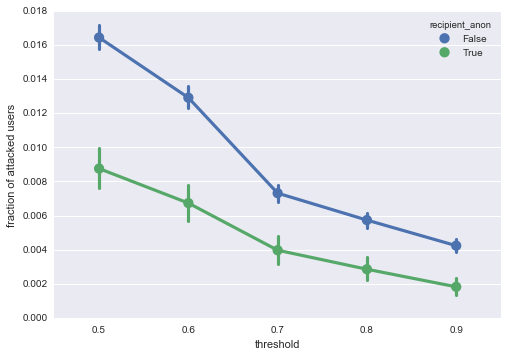

In [47]:
dfs = []

for t in ts:
    
    dfs.append (\
                df_no_admin_2015.query('not own_page')\
                .assign(attack = lambda x: x.pred_recipient_score >= t)\
                .groupby(['page_title', 'recipient_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'recipient_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacked users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have received at least 1 attack. Repeat.

In [49]:
n_attacks = [simulate_num_attacks(df_no_admin_2015, group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(df_no_admin_2015.page_title.unique()) 

array([ 0.097229  ,  0.09903882])

In [50]:
# ignore anon users
d_temp = df_no_admin_2015.query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp, group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.page_title.unique()) 

array([ 0.10052287,  0.10261987])

### Q: What fraction of attacking users have been blocked for harassment?

TODO: Also consider just registered users 

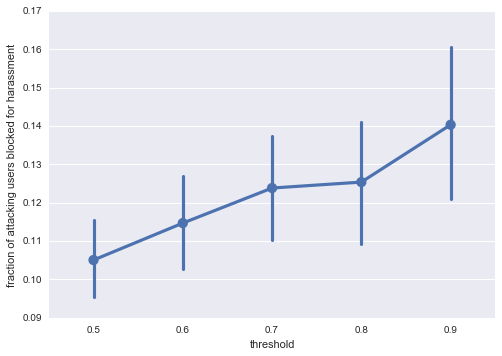

In [83]:
dfs = []

for t in ts:
    dfs.append(\
                df_no_admin_2015.query('pred_recipient_score >= %f' % t)[['user_text', 'author_anon']]\
                .drop_duplicates()\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking users blocked for harassment')

### Q: What fraction of attacking comments come from users blocked for harassment?

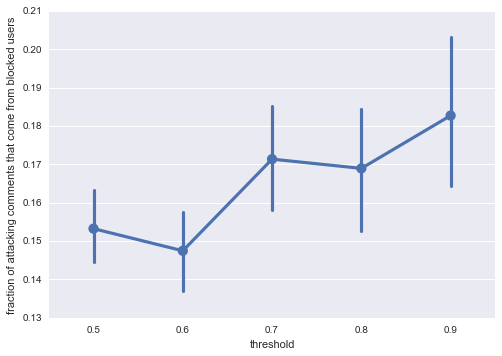

In [84]:
dfs = []

df_blocked_user = df_blocked_user.assign(blocked = 1)

for t in ts:
    dfs.append(\
                df_no_admin_2015.query('pred_recipient_score >= %f' % t)[['rev_id', 'author_anon']]\
                .merge(df_blocked_user, how = 'left', on = 'rev_id')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking comments that come from blocked users')

### Q: What fraction of attacking comments were followed by a block event?
Within one week

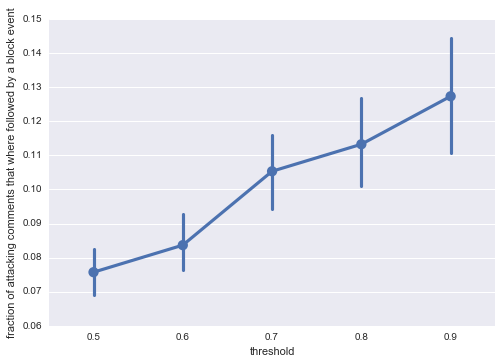

In [85]:
dfs = []
for t in ts:
    
    dfs.append(
                df_no_admin_2015.query('pred_recipient_score >= %f' % t)\
                        .loc[:, ['user_text', 'rev_id', 'rev_timestamp']]\
                        .merge(df_events, how = 'left', on = 'user_text')\
                        .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']))\
                        .assign(blocked= lambda x: (x['delta'] <  pd.Timedelta('7 days')) & (x['delta'] >  pd.Timedelta('0 seconds')))\
                        .drop_duplicates(subset = 'rev_id')\
                        .assign(threshold = t)
                )
ax = sns.pointplot(x='threshold', y='blocked', data = pd.concat(dfs))
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that where followed by a block event')

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

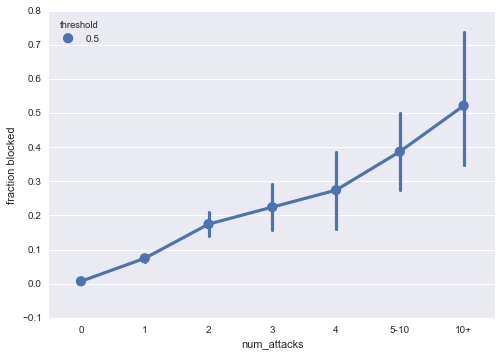

In [86]:
def remap(x):
    if x < 5:
        return str(int(x))
    if x < 10:
        return '5-10'
    else:
        return '10+'
    
t = 0.5 

        
d_temp = df_no_admin_2015.assign(attack = lambda x: x.pred_recipient_score >=  t)\
                .groupby('user_text', as_index = False)['attack'].sum()\
                .rename(columns={'attack':'num_attacks'})\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(
                    blocked = lambda x: x.blocked.fillna(0,),
                    num_attacks = lambda x: x.num_attacks.apply(remap),
                    threshold = t)
                
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=d_temp, hue = 'threshold', order = ('0', '1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

### Q: How are aggression and personal attacks related? Is it just the attacks that are aggressive or are their other types if aggression?

Methodology: check pearson correlation between aggression and attack scores for sample or unsampled data.

In [78]:
d_temp = d_annotated.dropna(subset=['aggression', 'recipient_score'])
pearson(d_temp['aggression'],d_temp['recipient_score'])

0.49449657698564492

In [79]:
d_temp = d_annotated.dropna(subset=['pred_aggression_score', 'pred_recipient_score'])
pearson(d_temp['pred_aggression_score'],d_temp['pred_recipient_score'])

0.56880114822703387

In [80]:
pearson(df_no_admin_sample['pred_aggression_score'],df_no_admin_sample['pred_recipient_score'])

0.55918406408876475

# Group Comparisons

Lets break down data into different groups and compare the mean aggression and attack scores

In [87]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def compare_groups(df, x, mpu = False, order = None, hue = None, plot = True, table = True):
    agg = 'pred_aggression_score'
    rec = 'pred_recipient_score'
    
    if table:
        if hue:
            print(df.groupby([x, hue])[agg, rec].mean())
        else:
            print(df.groupby([x])[agg, rec].mean())
    
    if plot:
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (12,6))

        if mpu:
            cols = ['user_text', x]
            plt.figure()
            sns.pointplot(x=x, y= agg, data=mpg(df, agg, cols) , order = order, hue = hue, ax = ax1)
            plt.figure()
            sns.pointplot(x=x, y= rec, data=mpg(df, rec, cols) , order = order, hue = hue, ax = ax2)
        else:
            
            ax = sns.pointplot(x=x, y= agg, data=df, order = order, hue = hue, ax = ax1)
            plt.figure()
            ax = sns.pointplot(x=x, y= rec, data=df, order = order, hue = hue, ax = ax2)
            

### Q: How do comments made by registered and anonymous authors compare?

             pred_aggression_score  pred_recipient_score
author_anon                                             
False                    -0.077602              0.032481
True                      0.226468              0.098044


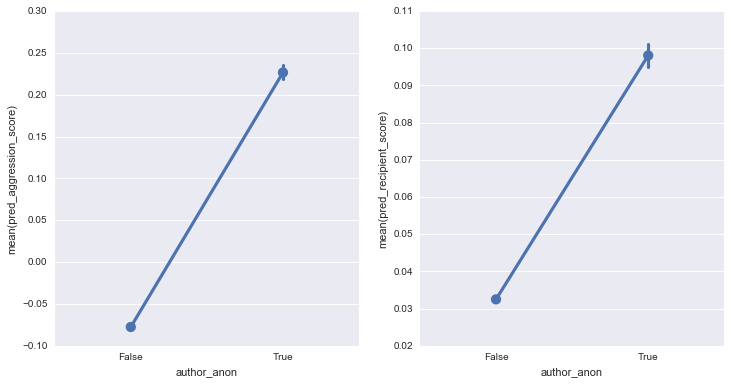

In [88]:
o = (False, True)
x = 'author_anon'
compare_groups(df_no_admin_sample, x, order = o)

In [119]:
#x = 'author_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do comments received by registered and anonymous authors compare?

                pred_aggression_score  pred_recipient_score
recipient_anon                                             
False                       -0.085833              0.034495
True                        -0.029572              0.030977


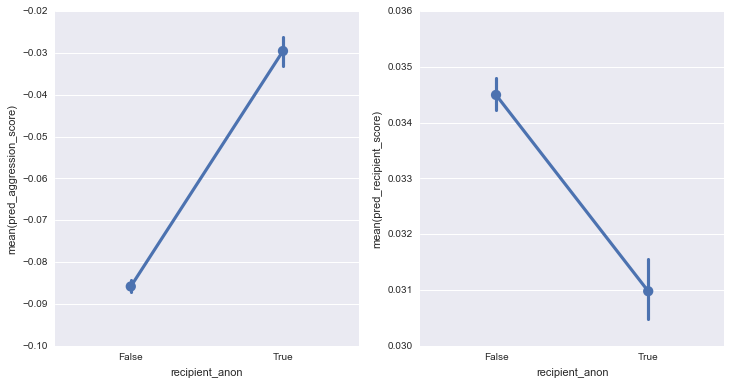

In [58]:
# don't count posts to own article
x = 'recipient_anon'
compare_groups(df_no_admin_sample.query('not own_page'), x, order = o)

In [59]:
#x = 'recipient_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do authors write differently on their own page than on other pages?

          pred_aggression_score  pred_recipient_score
own_page                                             
False                 -0.078094              0.034011
True                  -0.009194              0.040873


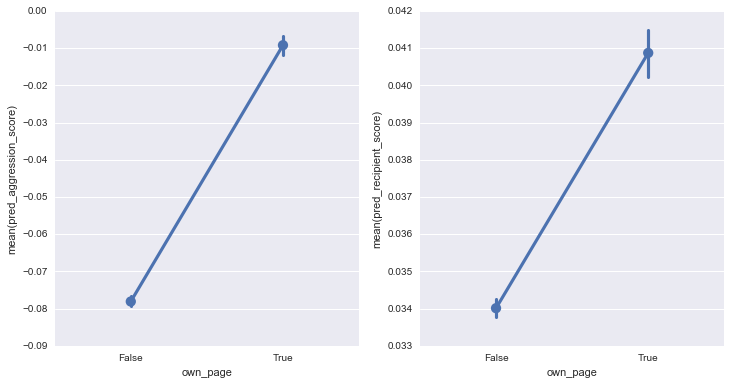

In [60]:
x = 'own_page'
o = (False, True)
compare_groups(df_no_admin_sample, x, order = o)

                      pred_aggression_score  pred_recipient_score
own_page author_anon                                             
False    False                    -0.090138              0.031485
         True                      0.193393              0.090962
True     False                    -0.028309              0.036400
         True                      0.328344              0.119857


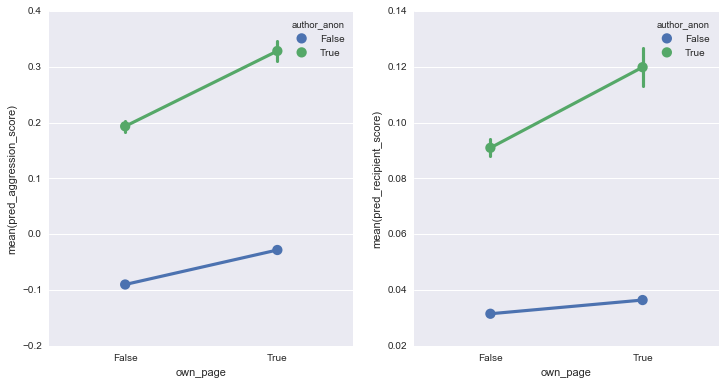

In [61]:
x = 'own_page'
compare_groups(df_no_admin_sample, x, order = o, hue = 'author_anon')

## Time

### Q: Has the amount of aggressiveness and attacks changed year over year?

In [164]:
df_span = df_no_admin_sample.query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
compare_groups(df_span, x, order = o, table = False)

UndefinedVariableError: name 'year' is not defined

### Q: Is there a seasonal effect?

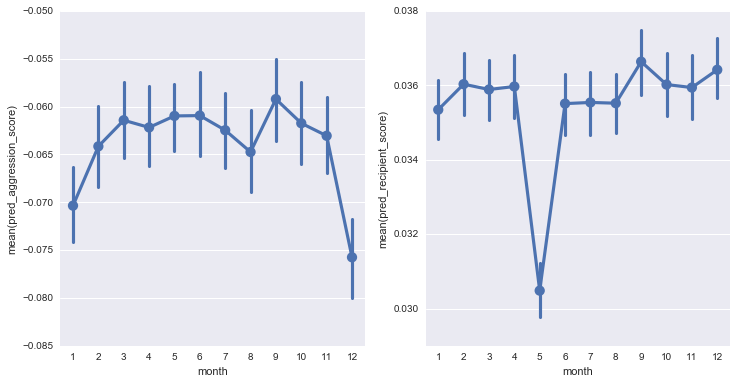

In [63]:
x = 'month'
o = range(1, 13)
compare_groups(df_no_admin_sample, x, order = o, table = False)

### Q: Is there an hour of day effect?

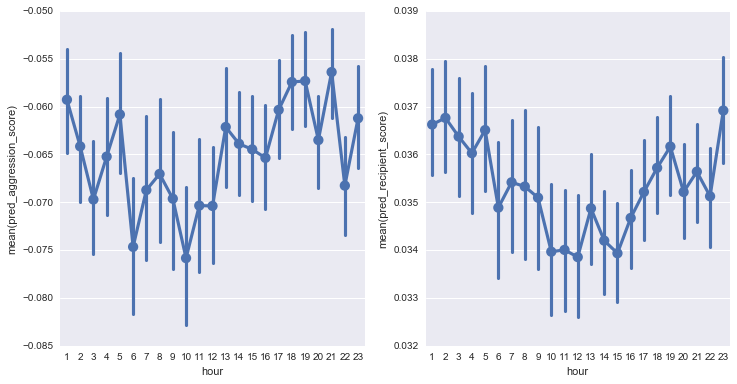

In [64]:
x = 'hour'
o  = range(1, 24)
compare_groups(df_no_admin_sample, x, order = o, table = False)

## Gender

In [150]:
from db_utils import query_analytics_store

In [214]:
## Annotate users by gender
query = """
SELECT
    user_id,
    user_name as user_text,
    up_value as gender
FROM
    enwiki.user_properties p,
    enwiki.user u
WHERE 
    p.up_user = u.user_id
    AND up_property = 'gender'
"""
#d_gender = query_analytics_store(query, {})
#d_gender.to_csv('genders.tsv', sep = '\t', index = False)
d_gender = pd.read_csv('genders.tsv', sep = '\t')

In [219]:
def remap_author_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['author_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
    
df_no_admin_gender = df_no_admin_2015.\
                     merge(d_gender, how = 'left', on = 'user_id', suffixes = ('', '_x')).\
                     assign(author_gender = lambda x: x.apply(remap_author_gender, axis = 1)).\
                     drop(['gender', 'user_text_x'], axis=1)

In [221]:
def remap_recipient_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['recipient_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
df_no_admin_gender = df_no_admin_gender.\
                     merge(d_gender, how = 'left', left_on = 'page_title', right_on = 'user_text', suffixes = ('', '_x')).\
                     assign(recipient_gender = lambda x: x.apply(remap_recipient_gender, axis = 1)).\
                     drop(['gender', 'user_text_x', 'user_id_x'], axis=1)

In [220]:
df_no_admin_gender.author_gender.value_counts()

unknown: registered    526238
male                   352870
unknown:anon            56624
female                  48662
Name: author_gender, dtype: int64

In [224]:
df_no_admin_gender.recipient_gender.value_counts()

unknown: registered    586002
male                   305094
unknown:anon            48434
female                  44864
Name: recipient_gender, dtype: int64

### Q: What is the effect of the author's gender?

                     pred_aggression_score  pred_recipient_score
author_gender                                                   
female                           -0.098558              0.033322
male                             -0.076705              0.030826
unknown: registered              -0.057319              0.037918
unknown:anon                      0.159108              0.077585


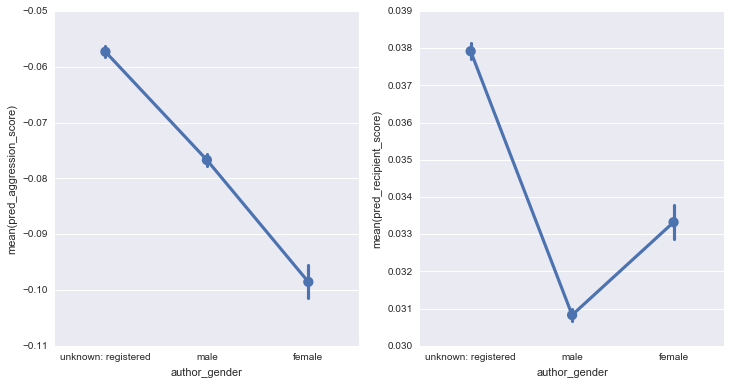

In [72]:
o = ('unknown: registered', 'male', 'female')
x = 'author_gender'
compare_groups(df_no_admin_gender, x, order = o)

### Q: What is the effect of the recipient's gender?

                     pred_aggression_score  pred_recipient_score
recipient_gender                                                
female                           -0.080636              0.037163
male                             -0.062367              0.038793
unknown: registered              -0.071134              0.036619
unknown:anon                     -0.006199              0.039928


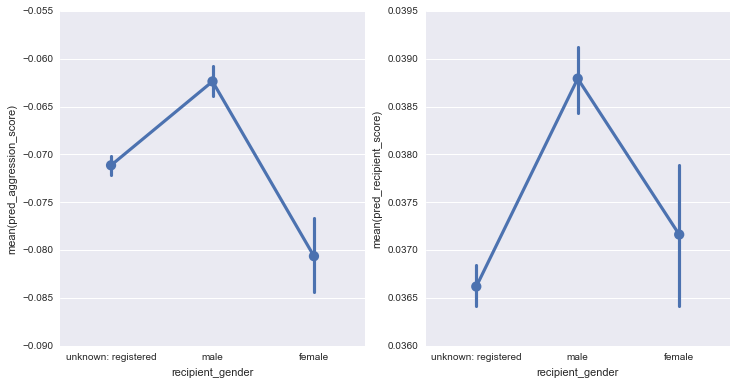

In [73]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query('not own_page'), x, order= o)

### Q: How does the effect change when you interact author and recipient gender?

                                         pred_aggression_score  \
recipient_gender    author_gender                                
female              female                           -0.123889   
                    male                             -0.083984   
                    unknown: registered              -0.093669   
male                female                           -0.114860   
                    male                             -0.086083   
                    unknown: registered              -0.072771   
unknown: registered female                           -0.105831   
                    male                             -0.076006   
                    unknown: registered              -0.085999   
unknown:anon        female                           -0.041382   
                    male                             -0.031785   
                    unknown: registered              -0.014535   

                                         pred_recipient_score  
recipient_g

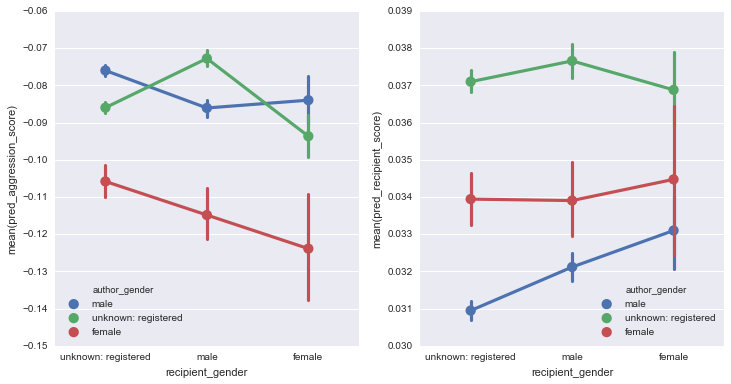

In [74]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query("not own_page and author_gender != 'unknown:anon'"), x, order = o, hue = 'author_gender')

### Q: Is tone reciprocal?

Methodology 1: is the average aggression score of what A says on B's page related to the average score of what B says on A's page?

In [222]:
pairs = df_no_admin_2015.query('not own_page and not author_anon and not recipient_anon').\
                         groupby(['user_text', 'page_title'], as_index = False)[['pred_aggression_score']].mean().\
                         assign(key = lambda x: 'From:' + x['user_text'] + ' to:' + x['page_title'],
                                partner_key = lambda x: 'From:' + x['page_title'] + ' to:' + x['user_text']
                               )
pairs = pairs.merge(pairs, left_on = 'partner_key', right_on = 'key', how = 'inner' )

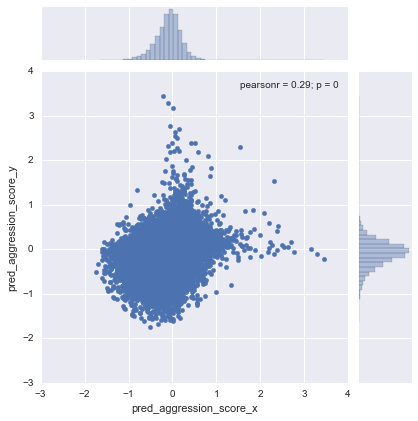

In [223]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = pairs)

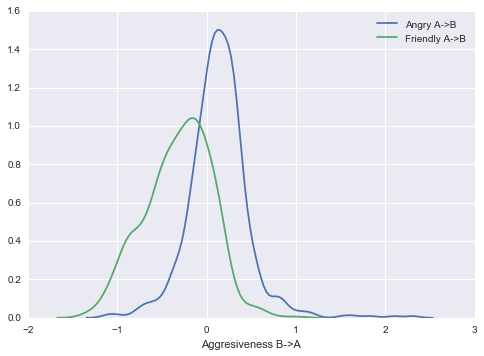

In [84]:
t_angry = np.percentile(pairs['pred_aggression_score_x'], 99)
t_friendly = np.percentile(pairs['pred_aggression_score_x'], 1)

sns.distplot(pairs.query('pred_aggression_score_x > %f' % t_angry)['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(pairs.query('pred_aggression_score_x < %f' % t_friendly)['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')
plt.xlabel('Aggresiveness B->A')

Methodology 2: is the aggression score of what A says on B's page related to the score of the next thing B says on A's page?

In [230]:
cols =  ['user_text', 'page_title', 'clean_diff', 'pred_aggression_score', 'rev_timestamp', 'rev_id']
ab = df_no_admin_2015.query('not own_page and not author_anon and not recipient_anon')[cols]
ba = ab.copy().rename(columns = {'user_text': 'page_title', 'page_title': 'user_text'})[cols]

micro_pairs = ab.merge(ba, on = ['user_text', 'page_title'], how = 'inner' )\
                .assign(delta = lambda x: x['rev_timestamp_x'] - x['rev_timestamp_y'])\
                .assign(delta_positive = lambda x: x.delta >  pd.Timedelta('0 seconds'),
                        delta_less_30 = lambda x: x.delta <  pd.Timedelta('30 days'))\
                .query('delta_positive and delta_less_30')\
                .sort('delta', ascending=False)\
                .groupby('rev_id_x', as_index=False).first()

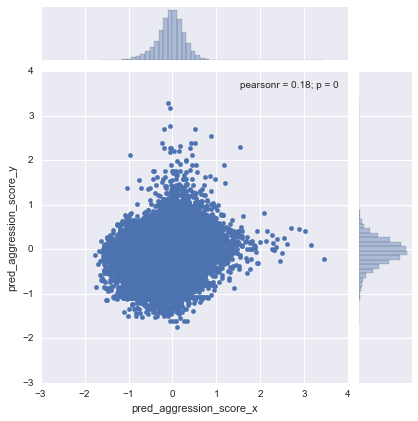

In [232]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = micro_pairs)

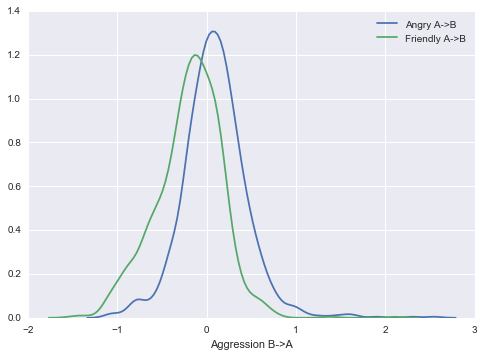

In [235]:
t_friendly, t_neutral, t_angry = np.percentile(micro_pairs['pred_aggression_score_x'], (1, 50, 99))


sns.distplot(micro_pairs.query('pred_aggression_score_x > %f' % t_angry)['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(micro_pairs.query('pred_aggression_score_x < %f' % t_friendly)['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')


#sns.distplot(d_temp.query('pred_aggression_score_x > 2')['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
#sns.distplot(d_temp.query('pred_aggression_score_x < -2')['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')
#sns.distplot(d_temp.query('pred_aggression_score_x > - 0.5 and pred_aggression_score_x <  0.5')['pred_aggression_score_y'], hist=False, label = 'Neutral A->B')
plt.xlabel('Aggression B->A')

#  How does tone depend on the frequency of commenting?

Methodology: let the "aggressiveness" of a user be the averge aggression_score of all their comments. Compare aggression scores across groups of users based on how much the post

In [239]:
tresholds = np.percentile(df_no_admin_2015['user_text'].value_counts(),  range(0, 101,2 ))
tresholds = sorted(set(tresholds.astype(int)))
tresholds

[1, 2, 3, 4, 5, 6, 8, 11, 15, 23, 58, 5239]

In [240]:
bins = []
for i in range(len(tresholds)-1):
    label = '%d-%d' % (tresholds[i], tresholds[i+1]-1)
    rnge = range(tresholds[i], tresholds[i+1])
    bins.append((label, rnge))
    
bins   

[('1-1', range(1, 2)),
 ('2-2', range(2, 3)),
 ('3-3', range(3, 4)),
 ('4-4', range(4, 5)),
 ('5-5', range(5, 6)),
 ('6-7', range(6, 8)),
 ('8-10', range(8, 11)),
 ('11-14', range(11, 15)),
 ('15-22', range(15, 23)),
 ('23-57', range(23, 58)),
 ('58-5238', range(58, 5239))]

In [241]:
def map_count(x):
    for label, rnge in bins:
        if x in rnge:
            return label
        
        
d_temp = df_no_admin_2015.query('not author_anon')\
                 .groupby('user_text')['pred_aggression_score']\
                 .agg( {'aggressiveness': np.mean, 'count': len})\
                 .assign(num_comment_range = lambda x: x['count'].apply(map_count))

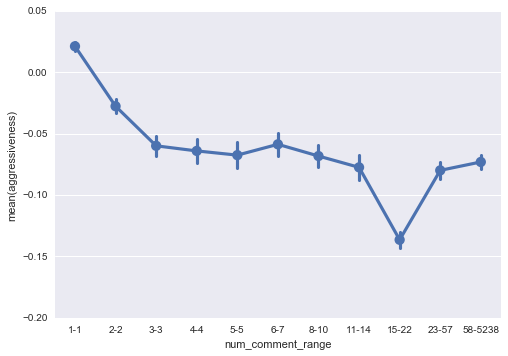

In [242]:
o = [e[0] for e in bins]
sns.pointplot(x='num_comment_range', y= 'aggressiveness', data= d_temp, order = o)

# Blocked Users

### Summary Stats

In [116]:
print('# block events:')
df_events.shape[0]

# block events:


27343

In [117]:
print('# block events')
df_events.groupby('anon').size()

# block events


anon
False    12377
True     14966
dtype: int64

In [118]:
print('# blocked users')
df_events.groupby('anon').user_text.nunique()

# blocked users


anon
False    10106
True     13562
Name: user_text, dtype: int64

In [193]:
print('# blocked users with a public talk comment')
df_blocked_user.groupby('author_anon').user_text.nunique()

# blocked useres with a public talk comment


author_anon
False    5872
True     6211
Name: user_text, dtype: int64

In [194]:
print('fraction of blocked users with a public talk comment')
df_blocked_user.groupby('author_anon').user_text.nunique() / df_events.groupby('anon').user_text.nunique() 

fraction of blocked users with a public talk comment


author_anon
False    0.581041
True     0.457971
Name: user_text, dtype: float64

### Q: How many users got blocked multiple times?

In [146]:
df_events.assign(block_count = 1)\
.groupby(['user_text', 'anon'], as_index = False)['block_count'].sum()\
.groupby(['anon', 'block_count']).size()

anon   block_count
False  1               8568
       2               1135
       3                235
       4                 91
       5                 42
       6                 16
       7                  8
       8                  5
       9                  3
       10                 1
       15                 1
       16                 1
True   1              12416
       2                964
       3                136
       4                 32
       5                  5
       6                  5
       7                  3
       10                 1
dtype: int64

### Q: P(blocked again | blocked at least k times)

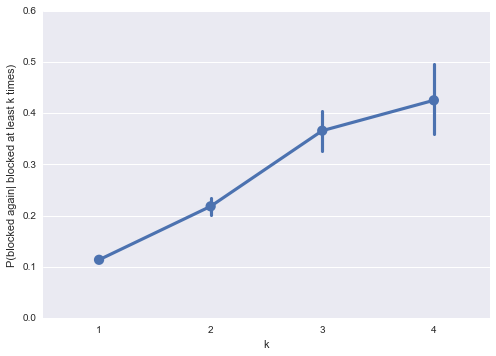

In [191]:
dfs = []

for k in range(1, 5):
    df_k = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%k)
    df_k1 = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%(k+1))\
            .assign(again = 1)
    df = df_k.merge(df_k1, how = 'left', on = 'user_text').assign(again = lambda x: x.again.fillna(0)).assign(k=k)
    dfs.append(df)

sns.pointplot(x = 'k', y = 'again', data = pd.concat(dfs))
plt.xlabel('k')
plt.ylabel('P(blocked again| blocked at least k times)')

### How does the number of block events vary over time?

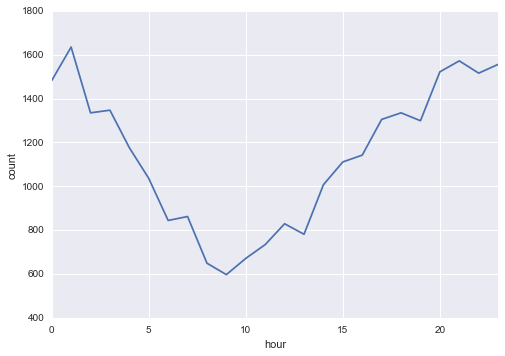

In [158]:
df_events.hour.value_counts().sort_index().plot()
plt.xlabel('hour')
plt.ylabel('count')

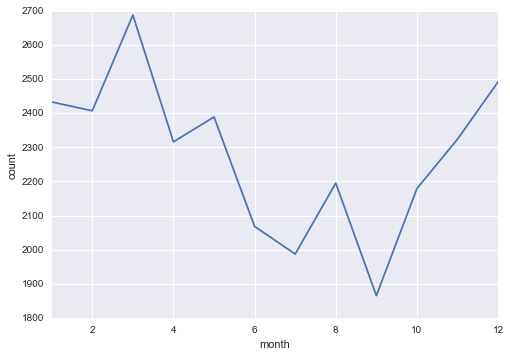

In [159]:
df_events.month.value_counts().sort_index().plot()
plt.xlabel('month')
plt.ylabel('count')

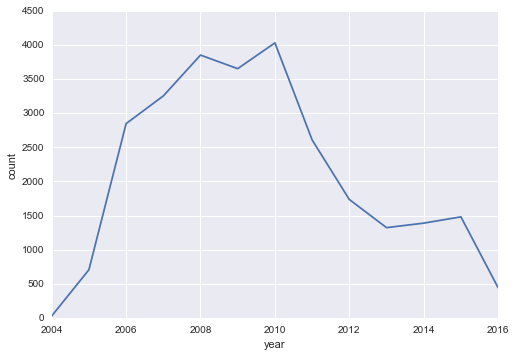

In [160]:
df_events.year.value_counts().sort_index().plot()
plt.xlabel('year')
plt.ylabel('count')

### How many blocked users have a public talk page comment after they where blocked?